In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import yfinance as yf
import datetime
import plotly.express as px
import plotly.figure_factory as ff 
from scipy.stats import shapiro, jarque_bera, norm, linregress
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pyfolio as pf 
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import statsmodels.tsa.api as tsa 
import warnings
# warnings.filterwarnings("ignore")

c:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
symbols = ['BTC-USD','AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'TSLA', '^GSPC']
# symbols = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'TSLA', '^GSPC']
symbols

['BTC-USD', 'AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'TSLA', '^GSPC']

In [12]:
data_list = []
for symbol in symbols:
    data = yf.download(symbol, start='2015-01-01')
    data['Symbol'] = symbol
    data_list.append(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
data_list

[                                   Open          High           Low  \
 Date                                                                  
 2015-01-01 00:00:00+00:00    320.434998    320.434998    314.002991   
 2015-01-02 00:00:00+00:00    314.079010    315.838989    313.565002   
 2015-01-03 00:00:00+00:00    314.846008    315.149994    281.082001   
 2015-01-04 00:00:00+00:00    281.145996    287.230011    257.612000   
 2015-01-05 00:00:00+00:00    265.084015    278.341003    265.084015   
 ...                                 ...           ...           ...   
 2023-01-25 00:00:00+00:00  22639.267578  23722.099609  22406.076172   
 2023-01-26 00:00:00+00:00  23108.955078  23237.078125  22911.373047   
 2023-01-27 00:00:00+00:00  23030.716797  23417.720703  22654.593750   
 2023-01-28 00:00:00+00:00  23079.964844  23165.896484  22908.845703   
 2023-01-29 00:00:00+00:00  23027.617188  23581.105469  22986.615234   
 
                                   Close     Adj Close       V

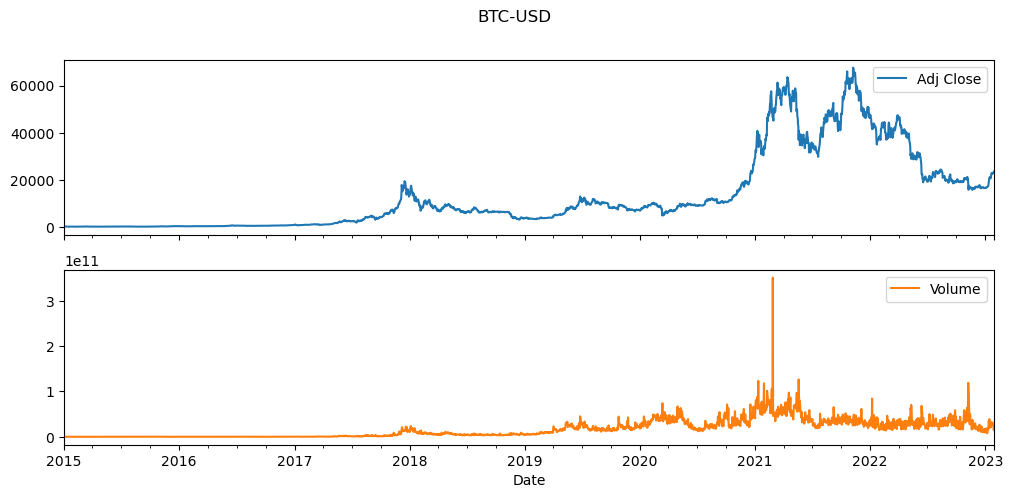

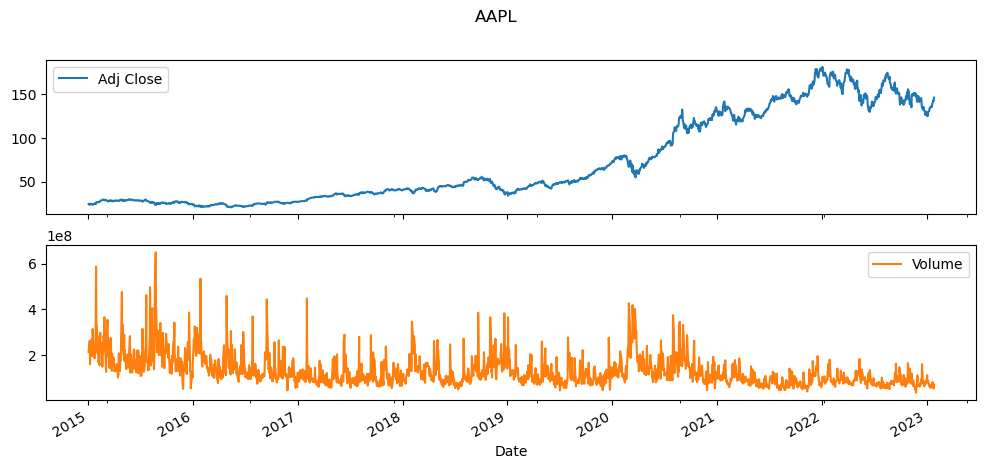

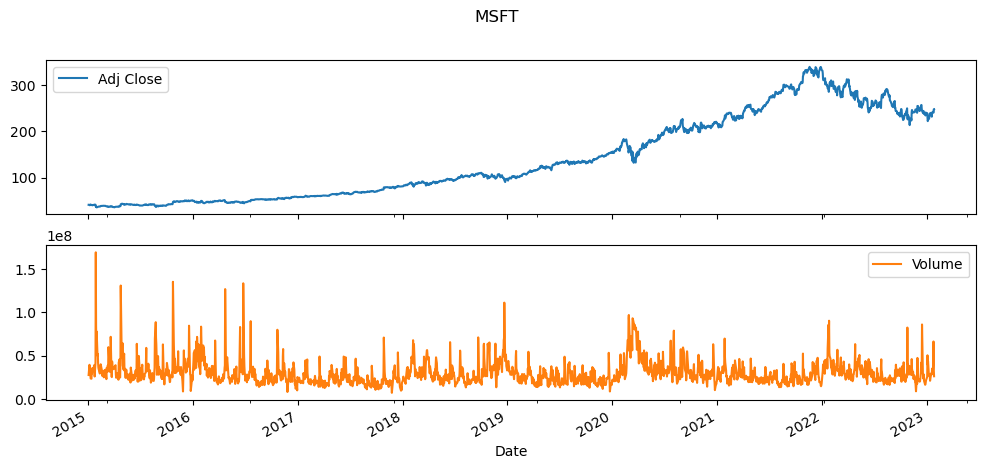

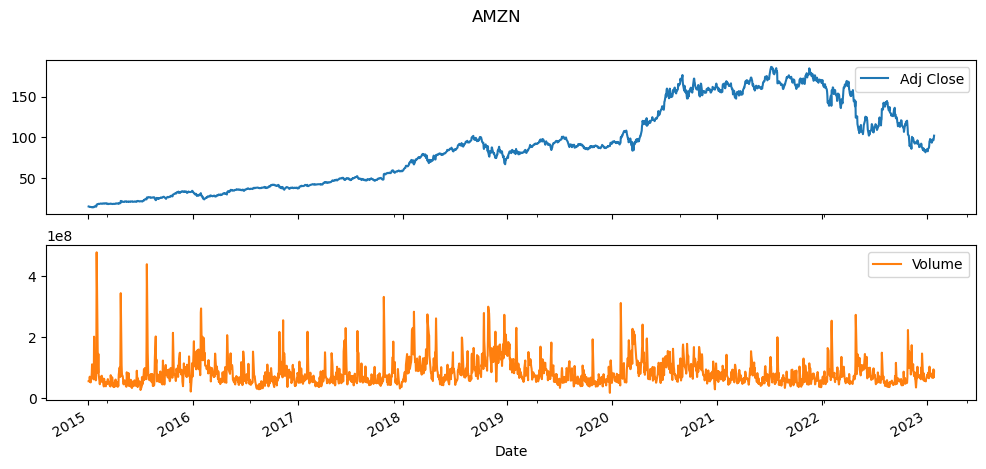

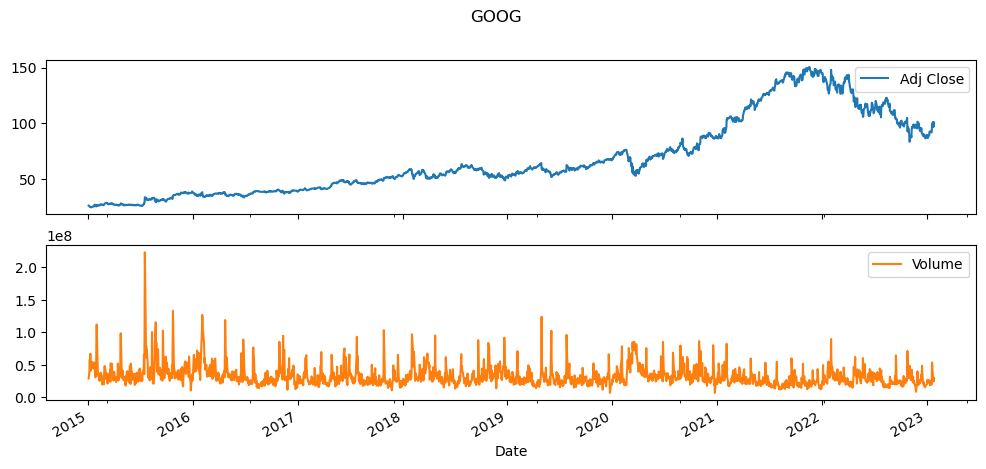

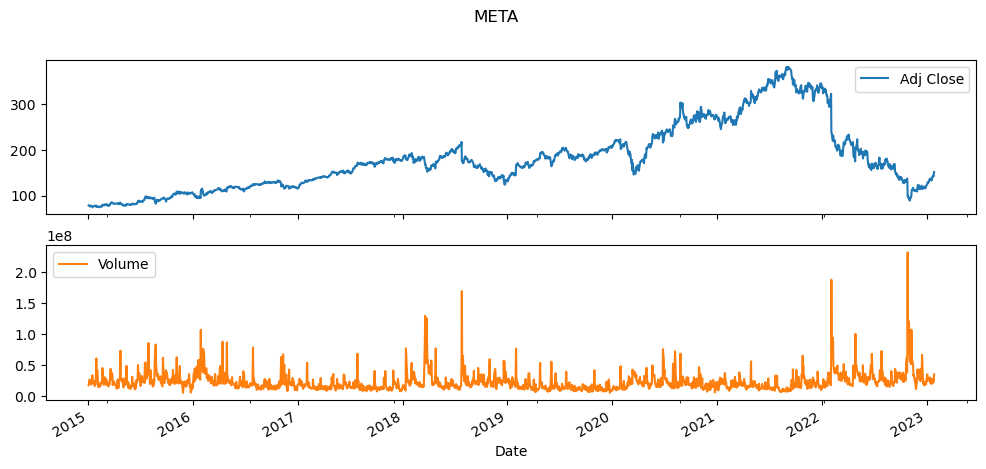

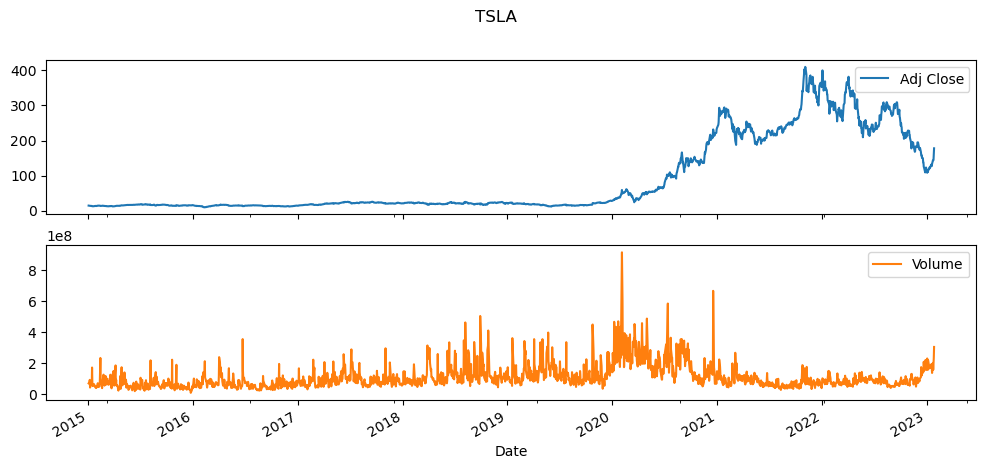

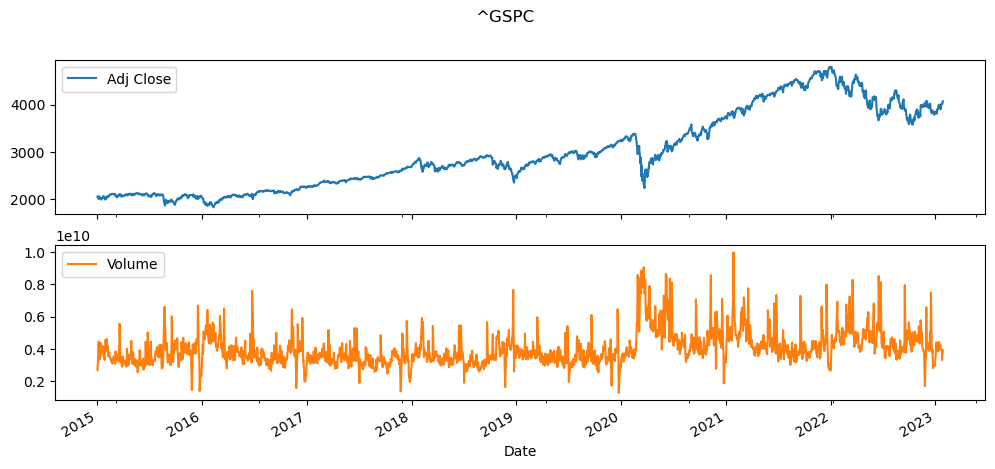

In [14]:
for i in range(0, len(data_list)):
    data_list[i][['Adj Close', 'Volume']].plot(subplots=True, title=data_list[i]['Symbol'].unique()[0], figsize=(12,5))
    plt.show()

In [56]:
all_data = pd.concat(data_list, axis=0)
all_data

Open         High          Low        Close  \
Date                                                                            
2015-01-01 00:00:00+00:00   320.434998   320.434998   314.002991   314.248993   
2015-01-02 00:00:00+00:00   314.079010   315.838989   313.565002   315.032013   
2015-01-03 00:00:00+00:00   314.846008   315.149994   281.082001   281.082001   
2015-01-04 00:00:00+00:00   281.145996   287.230011   257.612000   264.195007   
2015-01-05 00:00:00+00:00   265.084015   278.341003   265.084015   274.473999   
...                                ...          ...          ...          ...   
2023-01-23 00:00:00-05:00  3978.139893  4039.310059  3971.639893  4019.810059   
2023-01-24 00:00:00-05:00  4001.739990  4023.919922  3989.790039  4016.949951   
2023-01-25 00:00:00-05:00  3982.709961  4019.550049  3949.060059  4016.219971   
2023-01-26 00:00:00-05:00  4036.080078  4061.570068  4013.290039  4060.429932   
2023-01-27 00:00:00-05:00  4053.719971  4094.209961  4048.699951  4070.560059   

                             Adj Close      Volume   Symbol  
Date                                                         
2015-01-01 00:00:00+00:00   314.248993     8036550  BTC-USD  
2015-01-02 00:00:00+00:00   315.032013     7860650  BTC-USD  
2015-01-03 00:00:00+00:00   281.082001    33054400  BTC-USD  
2015-01-04 00:00:00+00:00   264.195007    55629100  BTC-USD  
2015-01-05 00:00:00+00:00   274.473999    43962800  BTC-USD  
...                                ...         ...      ...  
2023-01-23 00:00:00-05:00  4019.810059  3945210000    ^GSPC  
2023-01-24 00:00:00-05:00  4016.949951  3320430000    ^GSPC  
2023-01-25 00:00:00-05:00  4016.219971  3724020000    ^GSPC  
2023-01-26 00:00:00-05:00  4060.429932  3809590000    ^GSPC  
2023-01-27 00:00:00-05:00  4070.560059  3907760000    ^GSPC  

[17175 rows x 7 columns]

In [80]:
def make_df(data, serie_name):
    df = data.reset_index()
    df.set_index(['Date', 'Symbol'], inplace=True)
    df = df[serie_name].unstack()
    df_new_index = pd.date_range(df.index.min(), df.index.max(), freq='D')
    df.reindex(df_new_index)
    df.fillna(0, inplace=True)
    
    return df

In [82]:
price_df = make_df(all_data, 'Adj Close')
price_df

Empty DataFrame
Columns: [AAPL, AMZN, BTC-USD, GOOG, META, MSFT, TSLA, ^GSPC]
Index: []

In [66]:
volume_df = make_df(all_data, 'Volume')
volume_df

Symbol                            AAPL        AMZN  BTC-USD        GOOG  \
Date                                                                      
2015-01-02 00:00:00-05:00  212818400.0  55664000.0      0.0  28951268.0   
2015-01-05 00:00:00-05:00  257142000.0  55484000.0      0.0  41196796.0   
2015-01-06 00:00:00-05:00  263188400.0  70380000.0      0.0  57998800.0   
2015-01-07 00:00:00-05:00  160423600.0  52806000.0      0.0  41301082.0   
2015-01-08 00:00:00-05:00  237458000.0  61768000.0      0.0  67071641.0   
...                                ...         ...      ...         ...   
2023-01-23 00:00:00-05:00   81760300.0  76501100.0      0.0  31791800.0   
2023-01-24 00:00:00-05:00   66435100.0  66929500.0      0.0  27391400.0   
2023-01-25 00:00:00-05:00   65799300.0  94261600.0      0.0  31000900.0   
2023-01-26 00:00:00-05:00   54105100.0  68523600.0      0.0  24542100.0   
2023-01-27 00:00:00-05:00   70492800.0  87678100.0      0.0  29011900.0   

Symbol                           META        MSFT         TSLA         ^GSPC  
Date                                                                          
2015-01-02 00:00:00-05:00  18177500.0  27913900.0   71466000.0  2.708700e+09  
2015-01-05 00:00:00-05:00  26452200.0  39673900.0   80527500.0  3.799120e+09  
2015-01-06 00:00:00-05:00  27399300.0  36447900.0   93928500.0  4.460110e+09  
2015-01-07 00:00:00-05:00  22045300.0  29114100.0   44526000.0  3.805480e+09  
2015-01-08 00:00:00-05:00  23961000.0  29645200.0   51637500.0  3.934010e+09  
...                               ...         ...          ...           ...  
2023-01-23 00:00:00-05:00  27470100.0  31934000.0  203119200.0  3.945210e+09  
2023-01-24 00:00:00-05:00  21970200.0  40234400.0  158699100.0  3.320430e+09  
2023-01-25 00:00:00-05:00  26622000.0  66526600.0  192734300.0  3.724020e+09  
2023-01-26 00:00:00-05:00  25482100.0  33454500.0  234815100.0  3.809590e+09  
2023-01-27 00:00:00-05:00  35746900.0  26480800.0  305632100.0  3.907760e+09  

[2032 rows x 8 columns]

In [67]:
print('Résumé statistique des prix')
display(price_df.describe())
print('\n')
print('Résumé statistique des volumes')
volume_df.describe()

Résumé statistique des prix


Symbol         AAPL         AMZN  BTC-USD         GOOG         META  \
count   2032.000000  2032.000000   2032.0  2032.000000  2032.000000   
mean      71.956286    88.343313      0.0    68.127902   181.071678   
std       49.646317    49.745206      0.0    34.211529    73.019964   
min       20.914911    14.347500      0.0    24.560070    74.050003   
25%       29.493453    41.127626      0.0    40.072626   125.044998   
50%       46.951473    87.130501      0.0    57.198999   170.955002   
75%      123.835993   126.782497      0.0    88.979748   209.857502   
max      180.959732   186.570496      0.0   150.709000   382.179993   

Symbol         MSFT         TSLA        ^GSPC  
count   2032.000000  2032.000000  2032.000000  
mean     139.551569    89.030359  2990.296063  
std       89.707737   108.158754   813.756049  
min       35.260525     9.578000  1829.079956  
25%       57.981589    16.273333  2268.899902  
50%      106.388741    21.995334  2802.580078  
75%      222.001087   179.912506  3710.617432  
max      339.924835   409.970001  4796.560059



Résumé statistique des volumes


Symbol          AAPL          AMZN  BTC-USD          GOOG          META  \
count   2.032000e+03  2.032000e+03   2032.0  2.032000e+03  2.032000e+03   
mean    1.312515e+08  8.264354e+07      0.0  3.275329e+07  2.377141e+07   
std     6.780152e+07  4.152360e+07      0.0  1.573677e+07  1.532768e+07   
min     3.519590e+07  1.762600e+07      0.0  6.936000e+06  5.913100e+06   
25%     8.589730e+07  5.581100e+07      0.0  2.333350e+07  1.492405e+07   
50%     1.118354e+08  7.126915e+07      0.0  2.897135e+07  2.002300e+07   
75%     1.558053e+08  9.687400e+07      0.0  3.737600e+07  2.739315e+07   
max     6.488252e+08  4.771220e+08      0.0  2.232980e+08  2.323166e+08   

Symbol          MSFT          TSLA         ^GSPC  
count   2.032000e+03  2.032000e+03  2.032000e+03  
mean    3.010190e+07  1.121110e+08  4.016937e+09  
std     1.383926e+07  8.033503e+07  9.901745e+08  
min     7.425600e+06  1.062000e+07  1.296530e+09  
25%     2.159240e+07  6.370012e+07  3.385465e+09  
50%     2.687210e+07  8.814045e+07  3.808925e+09  
75%     3.426740e+07  1.287540e+08  4.410502e+09  
max     1.691640e+08  9.140820e+08  9.976520e+09

Visualisation interactive

In [68]:
def plotly_plot(data, title):
    fig = px.line(title=title)
    for i in data.columns:
        fig.add_scatter(x=data.index, y=data[i], name=i)
    fig.show()

In [69]:
plotly_plot(volume_df, "Nombre d'actions négociés par jour")

In [ ]:
plotly_plot(price_df, "Evolution du prix des actions")

Normalisation des données

In [ ]:
# Fonction de normalisation
def normalize(data):
    x = data.copy()
    for i in x.columns:
        x[i] = x[i]/x[i][0]
    return x

In [ ]:
normalize(price_df)

Symbol                         AAPL      AMZN      GOOG      META      MSFT  \
Date                                                                          
2015-01-02 00:00:00-05:00  1.000000  1.000000  1.000000  1.000000  1.000000   
2015-01-05 00:00:00-05:00  0.971828  0.979483  0.979154  0.983939  0.990804   
2015-01-06 00:00:00-05:00  0.971920  0.957118  0.956460  0.970682  0.976262   
2015-01-07 00:00:00-05:00  0.985548  0.967263  0.954822  0.970682  0.988665   
2015-01-08 00:00:00-05:00  1.023415  0.973875  0.957832  0.996558  1.017750   
...                             ...       ...       ...       ...       ...   
2023-01-23 00:00:00-05:00  5.735432  6.321794  3.867604  1.826259  5.943922   
2023-01-24 00:00:00-05:00  5.793148  6.244004  3.791177  1.824602  5.930690   
2023-01-25 00:00:00-05:00  5.765916  6.299754  3.696407  1.803697  5.895651   
2023-01-26 00:00:00-05:00  5.851271  6.431998  3.789267  1.877629  6.076728   
2023-01-27 00:00:00-05:00  5.931341  6.627771  3.848498  1.934226  6.080648   

Symbol                          TSLA     ^GSPC  
Date                                            
2015-01-02 00:00:00-05:00   1.000000  1.000000  
2015-01-05 00:00:00-05:00   0.957959  0.981722  
2015-01-06 00:00:00-05:00   0.963385  0.972991  
2015-01-07 00:00:00-05:00   0.961880  0.984307  
2015-01-08 00:00:00-05:00   0.960376  1.001914  
...                              ...       ...  
2023-01-23 00:00:00-05:00   9.831972  1.953071  
2023-01-24 00:00:00-05:00   9.841548  1.951681  
2023-01-25 00:00:00-05:00   9.878481  1.951326  
2023-01-26 00:00:00-05:00  10.961880  1.972806  
2023-01-27 00:00:00-05:00  12.167707  1.977728  

[2032 rows x 7 columns]

In [ ]:
plotly_plot(normalize(price_df), 'Prix normalisés')

In [ ]:
# % de variation du prix de TSLA depuis le 01.01.2015
((12.167707-1)/1)*100

1116.7707

In [ ]:
for i in price_df.columns:
    init = price_df[i][0]
    fin = price_df[i][-1]
    print(i, ' -> ', round(((fin-init)/init)*100,2), '%')

AAPL  ->  493.13 %
AMZN  ->  562.78 %
GOOG  ->  284.85 %
META  ->  93.42 %
MSFT  ->  508.06 %
TSLA  ->  1116.77 %
^GSPC  ->  97.77 %


Rendements et risques

In [ ]:
# Nombre de jours de trading dans une année
n_days = 252

In [ ]:
# Rendements journalier
returns = price_df.pct_change()
returns = returns.dropna()
returns

Symbol                         AAPL      AMZN      GOOG      META      MSFT  \
Date                                                                          
2015-01-05 00:00:00-05:00 -0.028172 -0.020517 -0.020846 -0.016061 -0.009196   
2015-01-06 00:00:00-05:00  0.000094 -0.022833 -0.023177 -0.013473 -0.014677   
2015-01-07 00:00:00-05:00  0.014022  0.010600 -0.001713  0.000000  0.012705   
2015-01-08 00:00:00-05:00  0.038422  0.006836  0.003153  0.026658  0.029418   
2015-01-09 00:00:00-05:00  0.001072 -0.011749 -0.012951 -0.005628 -0.008405   
...                             ...       ...       ...       ...       ...   
2023-01-23 00:00:00-05:00  0.023500  0.002776  0.019440  0.027983  0.009824   
2023-01-24 00:00:00-05:00  0.010063 -0.012305 -0.019761 -0.000907 -0.002226   
2023-01-25 00:00:00-05:00 -0.004701  0.008929 -0.024997 -0.011457 -0.005908   
2023-01-26 00:00:00-05:00  0.014803  0.020992  0.025121  0.040989  0.030714   
2023-01-27 00:00:00-05:00  0.013684  0.030437  0.015631  0.030143  0.000645   

Symbol                         TSLA     ^GSPC  
Date                                           
2015-01-05 00:00:00-05:00 -0.042041 -0.018278  
2015-01-06 00:00:00-05:00  0.005664 -0.008893  
2015-01-07 00:00:00-05:00 -0.001562  0.011630  
2015-01-08 00:00:00-05:00 -0.001564  0.017888  
2015-01-09 00:00:00-05:00 -0.018802 -0.008404  
...                             ...       ...  
2023-01-23 00:00:00-05:00  0.077425  0.011881  
2023-01-24 00:00:00-05:00  0.000974 -0.000712  
2023-01-25 00:00:00-05:00  0.003753 -0.000182  
2023-01-26 00:00:00-05:00  0.109673  0.011008  
2023-01-27 00:00:00-05:00  0.110002  0.002495  

[2031 rows x 7 columns]

In [ ]:
plotly_plot(returns, 'Rendement journalier des actions')

In [ ]:
returns.corr()

Symbol      AAPL      AMZN      GOOG      META      MSFT      TSLA     ^GSPC
Symbol                                                                      
AAPL    1.000000  0.582904  0.635397  0.558579  0.706684  0.431390  0.762445
AMZN    0.582904  1.000000  0.663648  0.592548  0.665916  0.399218  0.625876
GOOG    0.635397  0.663648  1.000000  0.656892  0.751480  0.382726  0.747358
META    0.558579  0.592548  0.656892  1.000000  0.591095  0.338632  0.620923
MSFT    0.706684  0.665916  0.751480  0.591095  1.000000  0.420742  0.814950
TSLA    0.431390  0.399218  0.382726  0.338632  0.420742  1.000000  0.463487
^GSPC   0.762445  0.625876  0.747358  0.620923  0.814950  0.463487  1.000000

In [ ]:
# fonction carte de corrélation
def plot_heatmap(df):
    cor_map = df.corr()
    plt.figure(figsize=(10,10))
    mask = np.triu(np.ones_like(cor_map, dtype=bool))
    sns.heatmap(cor_map, mask=mask, center=0, cmap='RdBu', linewidths=1, annot=True, fmt='.2f', vmin=-1, vmax=1)
    plt.title('Carte des corrélations', fontsize=15, fontweight='bold')
    plt.show()

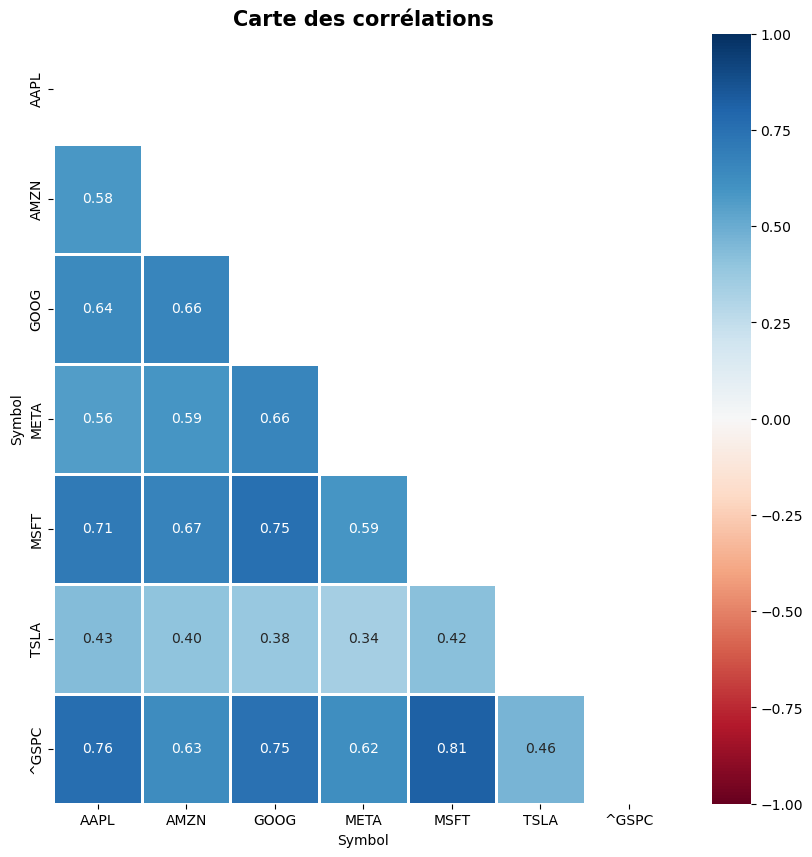

In [ ]:
plot_heatmap(returns)

In [ ]:
# Rendement journalier moyen
returns.mean()*100

Symbol
AAPL     0.105452
AMZN     0.115103
GOOG     0.082307
META     0.060699
MSFT     0.104663
TSLA     0.187726
^GSPC    0.040657
dtype: float64

In [ ]:
# Rendement moyen annuel
returns.mean()*n_days *100

Symbol
AAPL     26.573922
AMZN     29.005900
GOOG     20.741433
META     15.296170
MSFT     26.374978
TSLA     47.306910
^GSPC    10.245575
dtype: float64

Mesure standard du risque: Volatilité

array([[<AxesSubplot: title={'center': 'AAPL'}>,
        <AxesSubplot: title={'center': 'AMZN'}>,
        <AxesSubplot: title={'center': 'GOOG'}>],
       [<AxesSubplot: title={'center': 'META'}>,
        <AxesSubplot: title={'center': 'MSFT'}>,
        <AxesSubplot: title={'center': 'TSLA'}>],
       [<AxesSubplot: title={'center': '^GSPC'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

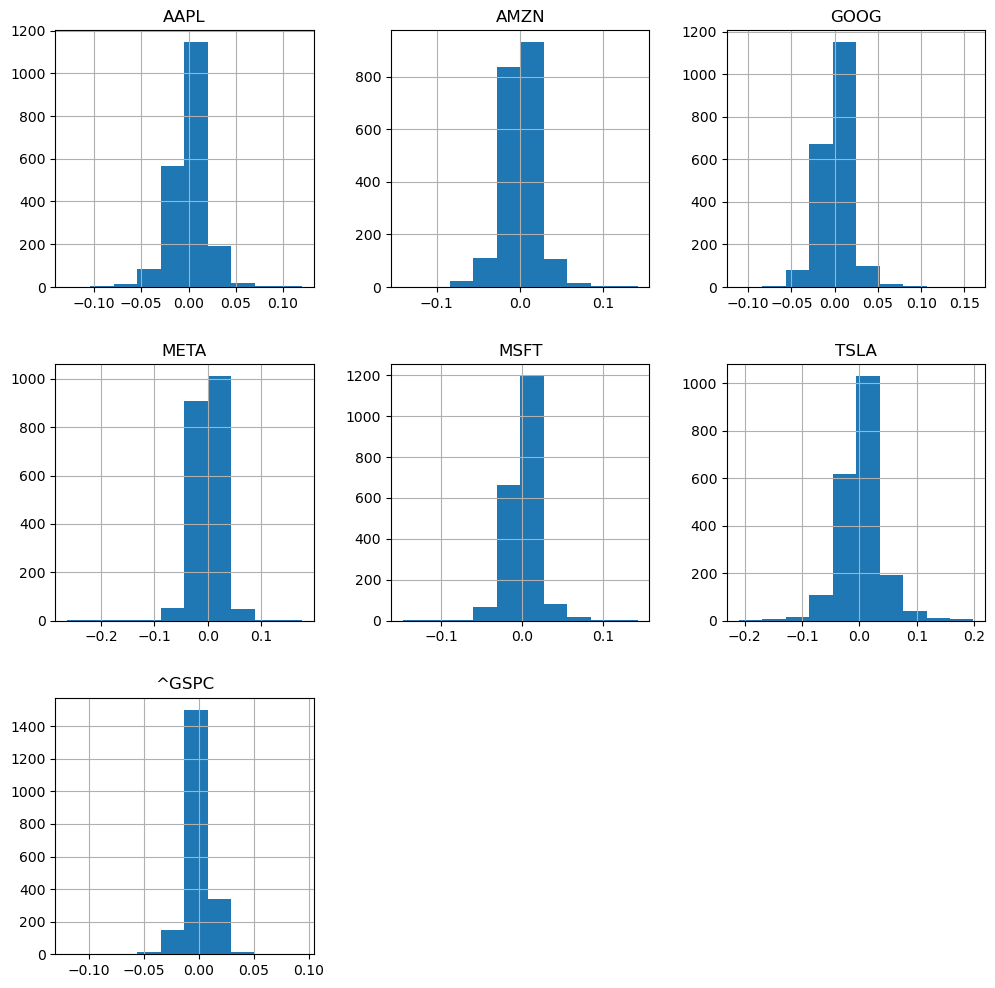

In [ ]:
#Histogrammes des rendements journaliers
returns.hist(figsize=( 12,12))

In [ ]:
# Stats sur les rendements journaliers
returns.describe()

Symbol         AAPL         AMZN         GOOG         META         MSFT  \
count   2031.000000  2031.000000  2031.000000  2031.000000  2031.000000   
mean       0.001055     0.001151     0.000823     0.000607     0.001047   
std        0.018846     0.021013     0.017886     0.023458     0.017753   
min       -0.128647    -0.140494    -0.111008    -0.263901    -0.147390   
25%       -0.007557    -0.008536    -0.006889    -0.009231    -0.006645   
50%        0.000888     0.001179     0.000907     0.000879     0.000868   
75%        0.010439     0.010982     0.009182     0.011992     0.009846   
max        0.119808     0.141311     0.160524     0.175936     0.142169   

Symbol         TSLA        ^GSPC  
count   2031.000000  2031.000000  
mean       0.001877     0.000407  
std        0.035994     0.011869  
min       -0.210628    -0.119841  
25%       -0.015099    -0.003828  
50%        0.001216     0.000570  
75%        0.018971     0.005755  
max        0.198949     0.093828

In [ ]:
# Volatilité journlières pour chaque action
returns.std()*100

Symbol
AAPL     1.884568
AMZN     2.101268
GOOG     1.788629
META     2.345793
MSFT     1.775310
TSLA     3.599429
^GSPC    1.186857
dtype: float64

In [ ]:
# Volatilité annualisée
for col in returns.columns:
    print("La volatilité annuelle de", col, ": ", round(returns[col].std()*np.sqrt(n_days)*100,2), '%')

La volatilité annuelle de AAPL :  29.92 %
La volatilité annuelle de AMZN :  33.36 %
La volatilité annuelle de GOOG :  28.39 %
La volatilité annuelle de META :  37.24 %
La volatilité annuelle de MSFT :  28.18 %
La volatilité annuelle de TSLA :  57.14 %
La volatilité annuelle de ^GSPC :  18.84 %


In [ ]:
#Volatilité mensuelle (21 jours)
for col in returns.columns:
    print("La volatilité mensuelle de", col, ": ", round(returns[col].std()*np.sqrt(21)*100,2), '%')

La volatilité mensuelle de AAPL :  8.64 %
La volatilité mensuelle de AMZN :  9.63 %
La volatilité mensuelle de GOOG :  8.2 %
La volatilité mensuelle de META :  10.75 %
La volatilité mensuelle de MSFT :  8.14 %
La volatilité mensuelle de TSLA :  16.49 %
La volatilité mensuelle de ^GSPC :  5.44 %


Ratio de Sharpe

In [ ]:
#Fonction Sharpe Ratio
def sharpe_ratio(serie, rf=0.025):
    '''
    serie: Série des rendements journaliers de l'action ou du portefeuille
    rf: rendement annuel d'un investissement sans risque (par défaut 2.5%)
    '''
    #Rendement annualisée
    rp = serie.mean()*n_days
    
    #Volatilité annuelle
    volatility = serie.std() * np.sqrt(n_days)
    
    sharpe = (rp-rf)/volatility
    return round(sharpe,2)

In [ ]:
for col in returns.columns:
    print('Sharpe ratio de ', col, ': ', sharpe_ratio(returns[col]))

Sharpe ratio de  AAPL :  0.8
Sharpe ratio de  AMZN :  0.79
Sharpe ratio de  GOOG :  0.64
Sharpe ratio de  META :  0.34
Sharpe ratio de  MSFT :  0.85
Sharpe ratio de  TSLA :  0.78
Sharpe ratio de  ^GSPC :  0.41
